# Time series
75033710 rows

13713 unique time series taken in 12603 stations from 17-10-2000 to 22-03-2018

In [3]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 

In [24]:
time_series_df = feather.read_feather('dataset/original_data_as_feather')

In [95]:
time_series_df.head()

,proj_id,name,date,groundwater_level
0,BB_25470023,Ottenhagen OP,2000-10-17 00:00:00+00:00,79.01
1,BB_25470023,Ottenhagen OP,2000-11-22 00:00:00+00:00,78.96
2,BB_25470023,Ottenhagen OP,2000-12-18 00:00:00+00:00,78.94
3,BB_25470023,Ottenhagen OP,2001-01-11 00:00:00+00:00,79.02
4,BB_25470023,Ottenhagen OP,2001-02-06 00:00:00+00:00,78.99


In [ ]:
len(time_series_df)

In [ ]:
len(time_series_df["proj_id"].unique())

In [ ]:
len(time_series_df["name"].unique())

In [ ]:
time_series_df.isnull().sum()

In [ ]:
pd.DataFrame(data=(time_series_df.loc[time_series_df.index[0]],time_series_df.loc[time_series_df.index[-1]]))

In [ ]:
t_s_1 = time_series_df[time_series_df["proj_id"]=="BB_25470023"]
plt.plot(t_s_1["date"],t_s_1["groundwater_level"])

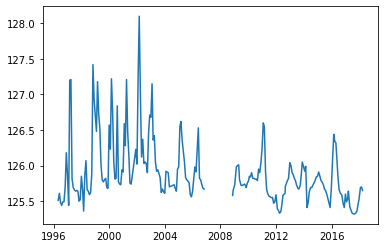

In [126]:
t_s_2 = time_series_df[time_series_df["proj_id"]==time_series_df["proj_id"].unique()[5002]]
plt.plot(t_s_2["date"],t_s_2["groundwater_level"])

In [127]:
len(t_s_2["date"].unique())

247

In [128]:
t_s_2["date"].unique()[10:20]

<DatetimeArray>
['1997-03-01 12:00:00+00:00', '1997-04-01 12:00:00+00:00',
 '1997-05-01 12:00:00+00:00', '1997-06-01 12:00:00+00:00',
 '1997-07-01 12:00:00+00:00', '1997-08-01 12:00:00+00:00',
 '1997-09-01 12:00:00+00:00', '1997-10-01 12:00:00+00:00',
 '1997-11-01 12:00:00+00:00', '1997-12-01 12:00:00+00:00']
Length: 10, dtype: datetime64[ns, UTC]

# metadata: 
respective observation wells ( stations),

related to the equipment used in the measurement e.g. coordinates, filter depth

13492 rows, 15 feature
latitude and longitude of stations are taken from here

In [3]:
meta_df = pd.read_excel("dataset/metadata_timeseries_LongLat.xlsx")
meta_df.head()

,proj_id,name,x_long,y_lat,x_utm32,y_utm32,aquifer_id,filteroberkante,filterunterkante,filter_length,filter_depth_middle,surface_elevation,watertable_pressure,well_depth,aquifer_level
0,BB_25470023,Ottenhagen OP,13.643609,53.416804,808527.0,5928687.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"100,33",gespannt,"62,53",NaN
1,BB_25470024,Ottenhagen UP,13.643653,53.416793,808530.0,5928686.0,tieferer GWL in tiefern quart. und tert. Schic...,NaN,NaN,NaN,NaN,"100,38",NaN,"45,68",NaN
2,BB_25480025,Neumannshof,13.826532,53.452024,820407.0,5933409.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"58,94",gespannt,"10,84",NaN
3,BB_25480026,Amalienhof,13.677407,53.457078,810477.0,5933310.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"97,67",gespannt,"62,67",NaN
4,BB_25481088,"Milow, Beschaffenheitsmesst.OP",13.821475,53.475857,819892.0,5936035.0,weitgehend unbedeckter GWL,NaN,NaN,NaN,NaN,"57,6",gespannt,"19,71",NaN


In [4]:
meta_df.shape

(13492, 15)

In [5]:
len(meta_df["y_lat"].unique())

12877

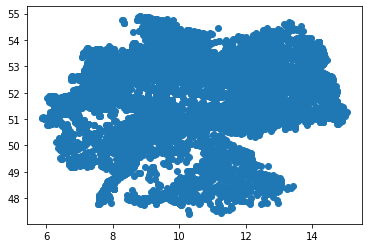

In [6]:
plt.scatter(meta_df["x_long"],meta_df["y_lat"])
plt.show()

 ### predictors ( temperature and precipitation) are matched to the station lon lat acording these meta data

# temperature: as predictor

Daily means of hourly grids of air temperature for whole Germany (project TRY Advancement)

there are 215 NC files, each file represents a month of dailly temperature from 01-1995 tp 11-2012



In [91]:
# extract relevant temp to T.S from an nc file 

In [7]:
# each nc file has temperature across whole germany
dir_01_2005 = "dataset/project_try_dwd/data/"+'daily_Project_TRY_air_temperature_mean__TT_200501_daymean.nc'
temp_01_2005 = netcdf.NetCDFFile(dir_01_2005,'r')

In [8]:
temp_01_2005.variables

OrderedDict([('lon', <scipy.io.netcdf.netcdf_variable at 0x7efe0c792f10>),
             ('lat', <scipy.io.netcdf.netcdf_variable at 0x7efdda2dc070>),
             ('time', <scipy.io.netcdf.netcdf_variable at 0x7efdda2d0eb0>),
             ('time_bnds',
              <scipy.io.netcdf.netcdf_variable at 0x7efdda2dc8e0>),
             ('datum', <scipy.io.netcdf.netcdf_variable at 0x7efdda2dc730>),
             ('temperature',
              <scipy.io.netcdf.netcdf_variable at 0x7efddb16c880>)])

In [9]:
# long and lat where temp was measured 
x_long = temp_01_2005.variables["lon"][:].flatten()
y_lat = temp_01_2005.variables["lat"][:].flatten()


In [10]:
938*720

675360

In [11]:
# create df to store the temp T.S for each station
station_temp_df =meta_df[["proj_id","x_long","y_lat"]]
station_temp_df.head()

,proj_id,x_long,y_lat
0,BB_25470023,13.643609,53.416804
1,BB_25470024,13.643653,53.416793
2,BB_25480025,13.826532,53.452024
3,BB_25480026,13.677407,53.457078
4,BB_25481088,13.821475,53.475857


In [14]:
# extract the indices of the temp

def temp_idx(df):
    # compute the temp_index according the closest long_lat
    long = df["x_long"]
    lat  = df["y_lat"]
    # compute the closest temp_long to the station- all occurances
    a = np.absolute(x_long - long)
    # compute the closest temp_lat to the station- all occurances
    b = np.absolute(y_lat - lat)

    if np.min(a) <= np.min(b):
        min_long = np.argwhere(a == np.min(a))
        idx = [int(i) for i in min_long if b[i] == np.min(b[min_long])][0]

    else:
        min_lat = np.argwhere(b == np.min(b))
        idx = [int(i) for i in min_lat if a[i] == np.min(a[min_lat])][0]
    
    return idx


#station_temp_df["idx"] = station_temp_df.apply(temp_idx,axis=1)  

<ipython-input-14-26e5be5b89ae>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_temp_df["Temp_"+str("20050103")] = station_temp_df.apply(temp_idx,axis=1)


In [15]:
station_temp_df.head()

,proj_id,x_long,y_lat,Temp_20050103
0,BB_25470023,13.643609,53.416804,515351
1,BB_25470024,13.643653,53.416793,515351
2,BB_25480025,13.826532,53.452024,522658
3,BB_25480026,13.677407,53.457078,584481
4,BB_25481088,13.821475,53.475857,557852


In [21]:
#station_temp_df = station_temp_df.rename(columns={"Temp_20050103":"idx"})

In [22]:
# save in temporary dataset file for later use
station_temp_df.to_csv("dataset/temporary/station_temp_df.csv", index=False)

In [23]:
temp_df = pd.read_csv("dataset/temporary/station_temp_df.csv")

,proj_id,x_long,y_lat,idx
0,BB_25470023,13.643609,53.416804,515351
1,BB_25470024,13.643653,53.416793,515351
2,BB_25480025,13.826532,53.452024,522658
3,BB_25480026,13.677407,53.457078,584481
4,BB_25481088,13.821475,53.475857,557852
...,...,...,...,...
13487,BW_9-768-5,10.066270,48.198413,115134
13488,BW_9851-512-1,9.257094,48.711200,147837
13489,BW_9901-064-8,7.819888,48.574195,138406
13490,BW_9902-064-3,7.819847,48.574212,138406


## extract the unique dates in the time series

In [4]:
# extract the dates in which water level were measured - in time_series_df
# store the unique values in numpy array as str
available_t_s_dates = pd.read_csv("dataset/temporary/dates_df.csv")
available_t_s_dates


/home/basem/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,dates
0,2000-10-17 00:00:00+00:00
1,2000-11-22 00:00:00+00:00
2,2000-12-18 00:00:00+00:00
3,2001-01-11 00:00:00+00:00
4,2001-02-06 00:00:00+00:00
...,...
75033705,2018-02-22 00:00:00+00:00
75033706,2018-03-01 00:00:00+00:00
75033707,2018-03-08 00:00:00+00:00
75033708,2018-03-15 00:00:00+00:00


In [10]:
df = available_t_s_dates.dropna()

In [ ]:
df = df.sort_values("dates")
df

In [9]:
# match to the lower date in temp data
df = df[df["dates"]>"1995-01-01 00:00:00+00:00"]
df

,dates
52876615,2012-12-31 00:05:00+00:00
57561160,2012-12-31 00:10:00+00:00
32871165,2012-12-31 00:15:00+00:00
25046536,2012-12-31 00:15:00+00:00
63908246,2012-12-31 00:25:00+00:00
...,...
19475407,2100-09-08 15:00:00+00:00
19475408,2100-09-08 18:00:00+00:00
19475409,2100-09-08 21:00:00+00:00
19475410,2100-09-09 00:00:00+00:00


In [8]:
# match to the upper date in temp
df = df[df["dates"]<'2012-12-31 00:00:00+00:00']
df

,dates
52876615,2012-12-31 00:05:00+00:00
57561160,2012-12-31 00:10:00+00:00
32871165,2012-12-31 00:15:00+00:00
25046536,2012-12-31 00:15:00+00:00
63908246,2012-12-31 00:25:00+00:00
...,...
19475407,2100-09-08 15:00:00+00:00
19475408,2100-09-08 18:00:00+00:00
19475409,2100-09-08 21:00:00+00:00
19475410,2100-09-09 00:00:00+00:00


# from here to be repaired 

## fine the uniqes dates, store them in a csv to avoid running the previous code again
## and then extract the corresponding temperature 

In [16]:

df =df["dates"].unique()
df

array(['2012-12-31 00:05:00+00:00', '2012-12-31 00:10:00+00:00',
       '2012-12-31 00:15:00+00:00', ..., '2100-09-08 21:00:00+00:00',
       '2100-09-09 00:00:00+00:00', '2100-11-01 00:00:00+00:00'],
      dtype=object)

In [1]:
#available_t_s_dates = available_t_s_dates["dates"].unique()
#available_t_s_dates

In [30]:
dates_df = pd.DataFrame({"dates":available_t_s_dates})
dates_df.head()

,dates
0,2000-10-17 00:00:00+00:00
1,2000-11-22 00:00:00+00:00
2,2000-12-18 00:00:00+00:00
3,2001-01-11 00:00:00+00:00
4,2001-02-06 00:00:00+00:00


In [31]:
dates_df.to_csv("dataset/temporary/dates_df.csv", index=False)

In [10]:
x = ["".join(str(pd.to_datetime(str(d)).date()).split("-")) for d in available_t_s_dates]

In [37]:
available_t_s_dates = pd.Series(available_t_s_dates)

In [48]:
 available_t_s_dates = available_t_s_dates[available_t_s_dates >'1995-01-01 00:00:00+00:00']

In [50]:
available_t_s_dates = available_t_s_dates.apply(lambda d :str(pd.to_datetime(str(d)).date()))

In [61]:
unique_date = available_t_s_dates[available_t_s_dates< "2012-12-30"].unique()

In [67]:
unique_date.shape

(6573,)

In [93]:
# extract and flatten all temp from an NC file
temp20050103 = temp_01_2005.variables["temperature"][2,:,:].flatten()
temp20050103.shape

(675360,)

In [92]:
# extract all the days in the corresponding NC file - one month
days = temp_01_2005.variables["datum"][:]
days = [str(x)[:-4] for x in days]

In [99]:
for day in days:
    print(day)

20050101
20050102
20050103
20050104
20050105
20050106
20050107
20050108
20050109
20050110
20050111
20050112
20050113
20050114
20050115
20050116
20050117
20050118
20050119
20050120
20050121
20050122
20050123
20050124
20050125
20050126
20050127
20050128
20050129
20050130
20050131


In [98]:
for day in days:
    if day in available_t_s_dates:
        print(day)

20050101
20050102
20050103
20050104
20050105
20050106
20050107
20050108
20050109
20050110
20050111
20050112
20050113
20050114
20050115
20050116
20050117
20050118
20050119
20050120
20050121
20050122
20050123
20050124
20050125
20050126
20050127
20050128
20050129
20050130
20050131


In [83]:
temp20050103[station_temp_df["Temp_20050103"][1000]]

40

In [ ]:
for d, day in enumerate(days):
    if day in available_t_s_dates:
 

In [ ]:
# check if the day of the month relevant to the time series
for d, day in enumerate(days):
    if day in available_t_s_dates:
        germany_temp_df["t_"+str(day)] = list(temp_01_2005.variables["temperature"][d,:,:].flatten())
        #bdf[str(d)] = temp_01_2005.variables["temperature"][d,:,:].flatten()
        #pd.merge(station_temp_df, germany_temp_df, on='x_long', how="left")

In [ ]:
germany_temp_df.head()